In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [488]:
gas = ct.Solution("2S_methane.cti")
# gas.Y = np.array([0.5, 0, 0.5, 0, 0])
# gas.TP = 1200, 101325
# reactor = ct.IdealGasReactor(gas)
# sim = ct.ReactorNet([reactor])
# sim.advance(5.93e-6)
#gas.Y = np.array([0.5, 0, 0.5, 0, 0, 0])
#gas.Y += 0.00001
gas.Y = np.ones(gas.n_species) / gas.n_species
#gas.Y = np.array([0.5, 0, 0, 0.5, 0, 0])
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
gas.TP = 500, 101325
np.save("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy", gas.Y)
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
gas()


  CH4_CM2:

       temperature             500  K
          pressure          101325  Pa
           density        0.601279  kg/m^3
  mean mol. weight         24.6697  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -4.8775e+06       -1.203e+08     J
   internal energy      -5.046e+06       -1.245e+08     J
           entropy          9181.5        2.265e+05     J/K
    Gibbs function     -9.4682e+06       -2.336e+08     J
 heat capacity c_p            1490        3.676e+04     J/K
 heat capacity c_v            1153        2.844e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.128493         0.166667         -27.1319
               H2O       0.228229         0.166667          -82.821
               CH4       0.256291         0.166667         -42.2379
                CO      

/home/darve/adncat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  """Entry point for launching an IPython kernel.


In [489]:
gas.density

0.601279332122976

In [490]:
r1 = ct.IdealGasReactor(gas)
res = ct.Reservoir(gas)
wall = ct.Wall(res, r1)
def Q(t):
    t0 = 1e-5
    r  = 1e-6
    c  = 1e12
    return c * np.exp(-(t - t0)**2 / r**2) 
wall.set_heat_flux(Q)
wall.area = 1.0
sim = ct.ReactorNet([r1]) 

In [491]:
#gas.TP = 1200, 101325
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
#reactor = ct.IdealGasReactor(gas)
#sim = ct.ReactorNet([reactor])
n_t = 2000
Pt = np.zeros(n_t)
Tt = np.zeros(n_t)
Yt = np.zeros((gas.n_species,n_t))
timestep = np.zeros(n_t+1)
timestep[0] = 0
dt = 0
t = 0
for i in range(n_t):
    if (n_t < 500):
        dt = 2e-6
    else:
        dt = 1e-11
    t += (i+1)*dt
    sim.advance(t)
    timestep[i+1] = t
    #timestep[i+1] = sim.step()
    Pt[i] = gas.P
    Tt[i] = gas.T
    Yt[:,i] = gas.Y
gas()


  CH4_CM2:

       temperature         3051.23  K
          pressure          671328  Pa
           density        0.601279  kg/m^3
  mean mol. weight         22.7222  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -9.8168e+05       -2.231e+07     J
   internal energy     -2.0982e+06       -4.768e+07     J
           entropy           12598        2.862e+05     J/K
    Gibbs function      -3.942e+07       -8.957e+08     J
 heat capacity c_p          2413.3        5.484e+04     J/K
 heat capacity c_v          2047.4        4.652e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2    7.33812e-05       0.00010334         -37.9803
               H2O       0.407432         0.323032         -38.0262
               CH4       0.137449        0.0970442         -35.8493
                CO      

In [492]:
timestep

array([0.000000e+00, 1.000000e-11, 3.000000e-11, ..., 1.997001e-05,
       1.999000e-05, 2.001000e-05])

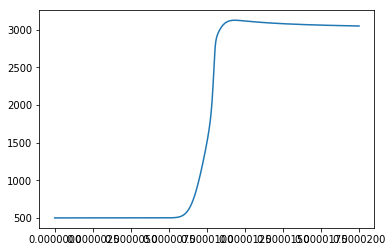

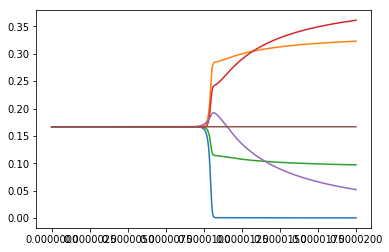

In [493]:
plt.plot(timestep[1:], Tt)
plt.figure()
for i in range(gas.n_species):
    plt.plot(timestep[1:], Yt[i,:])
####

In [494]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pressure.npy', Pt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature.npy', Tt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/mass_fraction.npy', Yt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy', timestep)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/density.npy', gas.density)
tbd = []
falofr = []
elmr = []
for i in range(gas.n_reactions):
    if (isinstance(gas.reaction(i), ct.ThreeBodyReaction)):
        tbd.append(i)
    elif (isinstance(gas.reaction(i), ct.FalloffReaction)):
        falofr.append(i)
    else:
        elmr.append(i)

NASA_coeffs = []
for i in range(gas.n_species):
    NASA_coeffs.append(gas.species(i).thermo.coeffs)
NASA_coeffs = np.array(NASA_coeffs)
reactants = []
orders = [] 
Af = np.zeros(len(elmr))
beta = np.zeros(len(elmr))
E = np.zeros(len(elmr))

rec2ind = dict()
for i in range(gas.n_species):
    reactants.append(gas.species(i).name)
    rec2ind[gas.species(i).name] = i
orders = gas.reactant_stoich_coeffs()[:,elmr]
for i, s in enumerate(elmr):   
    Af[i] = gas.reaction(s).rate.pre_exponential_factor
    beta[i] = gas.reaction(s).rate.temperature_exponent
    E[i] = gas.reaction(s).rate.activation_energy
    for rec in gas.reaction(s).orders:
        orders[rec2ind[rec], i] = gas.reaction(s).orders[rec]
reversible = np.array([int(gas.reaction(i).reversible) for i in range(gas.n_reactions)])

np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/NASA_coeffs.npy', NASA_coeffs)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/molecular_weights.npy',gas.molecular_weights)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reactants_stoich_coeffs.npy',gas.reactant_stoich_coeffs())
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/product_stoich_coeffs.npy',gas.product_stoich_coeffs())
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders.npy',orders)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy', Af)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy', beta)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy', E)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/delta_standard_entropy.npy', gas.delta_standard_entropy)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/delta_standard_enthalpy.npy', gas.delta_standard_enthalpy)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reversible.npy', reversible)

efficiency_f = np.zeros((gas.n_species, len(falofr)))
Af_lo = np.zeros(len(falofr))
beta_lo = np.zeros(len(falofr))
E_lo = np.zeros(len(falofr))
Af_hi = np.zeros(len(falofr))
beta_hi = np.zeros(len(falofr))
E_hi = np.zeros(len(falofr))
orders_f = gas.reactant_stoich_coeffs()[:,falofr]
falloff_parameters = np.zeros((4, len(falofr)))
troefall = []
troefall_coeff = []
for i, s in enumerate(falofr):
    rr = gas.reaction(s)
    Af_lo[i] = rr.low_rate.pre_exponential_factor
    beta_lo[i] = rr.low_rate.temperature_exponent
    E_lo[i] = rr.low_rate.activation_energy
    Af_hi[i] = rr.high_rate.pre_exponential_factor
    beta_hi[i] = rr.high_rate.temperature_exponent
    E_hi[i] = rr.high_rate.activation_energy
    efficiency_f[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    if(isinstance(rr.falloff, ct.TroeFalloff)):
        troefall.append(i)
        troefall_coeff.append(rr.falloff.parameters)
    #falloff_parameters[:,i] = gas.reaction(s).falloff.parameters
    for rec in rr.efficiencies:
        efficiency_f[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_f[rec2ind[rec], i] = gas.reaction(s).orders[rec]

np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/efficiency_f.npy', efficiency_f)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/troefall_coeff.npy', np.array(troefall_coeff).T)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/troefall.npy', troefall)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders_f.npy',orders_f)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy', Af_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy', beta_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy', E_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy', Af_lo)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy', beta_lo)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy', E_lo)

efficiency_t = np.zeros((gas.n_species, len(tbd)))
Af_t = np.zeros(len(tbd))
beta_t = np.zeros(len(tbd))
E_t = np.zeros(len(tbd))
orders_t = gas.reactant_stoich_coeffs()[:,tbd]
for i, s in enumerate(tbd):
    rr = gas.reaction(s)
    Af_t[i] = rr.rate.pre_exponential_factor
    beta_t[i] = rr.rate.temperature_exponent
    E_t[i] = rr.rate.activation_energy
    efficiency_t[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    for rec in rr.efficiencies:
        efficiency_t[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_t[rec2ind[rec], i] = gas.reaction(s).orders[rec]
        
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/efficiency_t.npy',efficiency_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders_t.npy',orders_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy', Af_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy', beta_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy', E_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy',tbd)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy',falofr)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy',elmr)

In [373]:
NASA_coeffs[:,0]

array([1000., 1000., 1000., 1000., 1000., 1000.])

In [66]:
ai = gas.reaction(0).low_rate.pre_exponential_factor
bi = gas.reaction(0).low_rate.temperature_exponent
ei = gas.reaction(0).low_rate.activation_energy
kf_o = ai * (gas.T**bi) * np.exp(-ei/(ct.gas_constant * gas.T)) * gas.concentrations.dot(efficiency_f[:,0])
kf_o

AttributeError: 'cantera._cantera.ElementaryReaction' object has no attribute 'low_rate'

In [189]:
kf_o / (1 + kf_o / kf_h)

5707642209.63778

In [39]:
gas()


  CH4_CM2:

       temperature         2303.31  K
          pressure          194991  Pa
           density        0.250533  kg/m^3
  mean mol. weight         24.6058  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -3.2548e+06       -8.009e+07     J
   internal energy     -4.0331e+06       -9.924e+07     J
           entropy           11871        2.921e+05     J/K
    Gibbs function     -3.0597e+07       -7.529e+08     J
 heat capacity c_p            2363        5.814e+04     J/K
 heat capacity c_v            2025        4.983e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2    4.87292e-05      6.33704e-05         -38.5507
               H2O       0.358341         0.262362         -41.1083
               CH4       0.190276         0.124058         -35.3318
                CO      

In [200]:
y2 - y1 = dt * fy2
y2 - (I - dt * J) / (y2 - y1 - dt * fy2)

Help on TroeFalloff object:

class TroeFalloff(Falloff)
 |  The 3- or 4-parameter Troe falloff function.
 |  
 |  :param params:
 |      An array of 3 or 4 parameters: :math:`[a, T^{***}, T^*, T^{**}]` where
 |      the final parameter is optional (with a default value of 0).
 |  
 |  Method resolution order:
 |      TroeFalloff
 |      Falloff
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __reduce__ = __reduce_cython__(...)
 |      TroeFalloff.__reduce_cython__(self)
 |  
 |  __setstate__ = __setstate_cython__(...)
 |      TroeFalloff.__setstate_cython__(self, __pyx_state)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  falloff_type = 110
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Falloff:


In [199]:
reactor = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([reactor])


In [200]:
tnow = 0
timestep = []
while (tnow < 0.005):
    tnow = sim.step()
    timestep.append(tnow)
    Tt[i] = gas.T
    print(tnow)
timestep = np.array(timestep)

1.3174855618911308e-09
2.6349711237822615e-09
6.230476723984772e-09
9.825982324187283e-09
1.3421487924389794e-08
1.7016993524592304e-08
2.4256755808813545e-08
3.7231272793505215e-08
6.004457322793608e-08
1.0005344738297945e-07
1.723444574261005e-07
3.294903960403123e-07
4.866363346545241e-07
6.437822732687359e-07
8.009282118829477e-07
1.0814563005326476e-06
1.3619843891823474e-06
1.6425124778320472e-06
1.923040566481747e-06
2.203568655131447e-06
2.7256655612658814e-06
3.2477624674003158e-06
3.76985937353475e-06
4.291956279669185e-06
5.171585793320537e-06
6.051215306971889e-06
6.930844820623241e-06
8.53733921332732e-06
1.0143833606031399e-05
1.1750327998735478e-05
1.3356822391439557e-05
1.4963316784143636e-05
1.7404048010683558e-05
1.9844779237223482e-05
2.2285510463763406e-05
2.472624169030333e-05
2.8528820136976796e-05
3.233139858365026e-05
3.613397703032373e-05
3.99365554769972e-05
4.78678669948579e-05
5.305649702663778e-05
5.8245127058417656e-05
6.343375709019753e-05
6.8622387121977

0.0016024152145097425
0.0016024174006692552
0.001602419586828768
0.0016024217729882807
0.0016024239591477935
0.0016024261453073062
0.001602428331466819
0.0016024305176263317
0.0016024327037858445
0.0016024348899453572
0.00160243707610487
0.0016024392622643827
0.0016024414484238955
0.0016024436345834082
0.001602445820742921
0.0016024480069024337
0.0016024501930619465
0.0016024523792214592
0.001602454565380972
0.0016024567515404847
0.0016024589376999975
0.0016024611238595102
0.001602463310019023
0.0016024654961785357
0.0016024676823380485
0.0016024698684975612
0.001602472054657074
0.0016024742408165867
0.0016024764269760995
0.0016024786131356122
0.001602480799295125
0.0016024829854546377
0.0016024851716141505
0.0016024873577736632
0.001602489543933176
0.0016024917300926887
0.0016024939162522015
0.0016024961024117142
0.001602498288571227
0.0016025004747307397
0.0016025026608902525
0.0016025048470497652
0.001602507033209278
0.0016025092193687907
0.0016025114055283035
0.0016025135916878162


0.0019062266634820386
0.001907369093243875
0.0019085115230057113
0.0019096539527675477
0.001910796382529384
0.0019119388122912204
0.0019138990549937725
0.0019152453356971705
0.0019165916164005684
0.0019179378971039664
0.0019192841778073644
0.0019206304585107623
0.0019219767392141603
0.0019233230199175583
0.0019246693006209562
0.0019260155813243542
0.0019273618620277522
0.0019287081427311501
0.0019300544234345481
0.001931400704137946
0.001932746984841344
0.001934093265544742
0.00193543954624814
0.001936785826951538
0.001938132107654936
0.001939478388358334
0.0019408246690617319
0.0019417262224253405
0.0019423402658279856
0.0019429543092306307
0.0019435683526332758
0.0019445326906840988
0.0019459936923502143
0.0019474546940163298
0.0019489156956824453
0.0019503766973485608
0.0019518376990146763
0.001953298700680792
0.0019547597023469076
0.001956220704013023
0.0019571442328752482
0.0019580677617374734
0.0019589912905996986
0.0019599148194619238
0.001960838348324149
0.001961761877186374
0.

In [204]:
Tt[0:100]

array([ 800.02026188, 2743.22362059,  800.0608942 ,  800.08126462,
        800.1016712 ,  800.12211391,  800.14259276,  800.16310772,
        800.18365879,  800.20424595,  800.22486918,  800.24552849,
        800.26622385,  800.28695526,  800.3077227 ,  800.32852616,
        800.34936564,  800.37024111,  800.39115258,  800.41210002,
        800.43308342,  800.45410279,  800.4751581 ,  800.49624935,
        800.51737653,  800.53853962,  800.55973862,  800.58097352,
        800.6022443 ,  800.62355096,  800.6448935 ,  800.66627189,
        800.68768613,  800.70913622,  800.73062214,  800.75214389,
        800.77370145,  800.79529482,  800.81692399,  800.83858896,
        800.86028971,  800.88202624,  800.90379854,  800.9256066 ,
        800.94745041,  800.96932998,  800.99124528,  801.01319632,
        801.03518309,  801.05720558,  801.07926379,  801.1013577 ,
        801.12348731,  801.14565262,  801.16785363,  801.19009031,
        801.21236268,  801.23467072,  801.25701443,  801.27939

In [339]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy', timestep)

In [253]:
time = np.zeros(timestep.shape[0]+1)

In [254]:
time[1:] = timestep

In [255]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy', time)

In [205]:
timestep.shape

(2132,)

In [185]:
gas.Y += 0.00001

In [186]:
np.sum(gas.Y)

0.9999999999999999

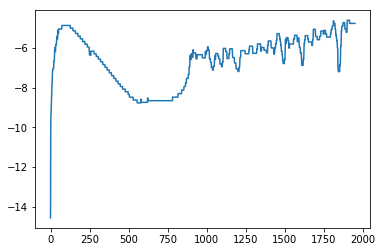

In [177]:
plt.plot(np.log(time[1:] - time[0:-1]) / np.log(10))

In [187]:
gas.Y

array([4.99980001e-01, 9.99940004e-06, 4.99980001e-01, 9.99940004e-06,
       9.99940004e-06, 9.99940004e-06])

In [248]:
a = np.arange(0, 0.00158+1e-6, 1e-6)

In [249]:
b = np.arange(0.00158, 0.00162+1e-8, 1e-8)

In [250]:
c = np.arange(0.00162, 0.002, 1e-8)

In [251]:
timestep = np.concatenate([a, b, c])

In [338]:
timestep = np.arange(0, 1e-8 * 2001, 1e-8)

In [252]:
timestep.shape

(43583,)

In [299]:
timestep

array([0.000e+00, 4.000e-09, 8.000e-09, ..., 7.992e-06, 7.996e-06,
       8.000e-06])

In [315]:
Tt_cant = py"np.load"("data/temperature.npy")

SyntaxError: invalid syntax (<ipython-input-315-ed67bc78ed50>, line 1)

In [310]:
gas.reaction(1)

<ElementaryReaction: CO + 0.5 O2 <=> CO2>

In [332]:
gas.reaction(0).rate

Arrhenius(A=2e+12, b=0, E=1.4644e+08)

In [333]:
gas.reaction(1).rate

Arrhenius(A=6.32456e+07, b=0, E=5.0208e+07)

In [119]:
tx = np.array([1e-8 * i for i in range(2000)])

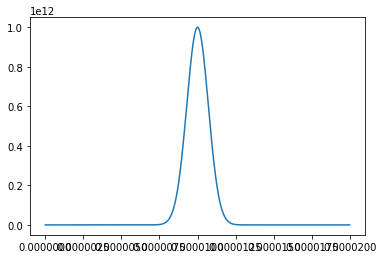

In [152]:
c = 1e12
t0 = 1e-5
r = 1e-6
q = lambda t : c * np.exp(-(t-t0)**2 / r**2)
plt.plot(tx, q(tx))

In [121]:
tx

array([0.000e+00, 1.000e-08, 2.000e-08, ..., 1.997e-05, 1.998e-05,
       1.999e-05])

In [122]:
q(tx)

array([5.e-07, 5.e-07, 5.e-07, ..., 5.e-07, 5.e-07, 5.e-07])